In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import numpy as np
import yfinance as yf
from scipy.stats import norm

In [2]:
yf.pdr_override()
tickers = "^BVSP ^GSPC GC=F USDBRL=X"
carteira = yf.download(tickers, interval='1mo', start="2008-01-01")["Close"]
carteira.columns = ["OURO", "DOLAR", "IBOV", "S&P500"]
carteira = carteira.dropna()
carteira["OURO_BRL"]=carteira["OURO"]*carteira["DOLAR"]
carteira["S&P500_BRL"]=carteira["S&P500"]*carteira["DOLAR"]

[*********************100%***********************]  4 of 4 completed


In [3]:
retornos = carteira.pct_change()[1:]

# Retornos Esperados e a Matriz de Covariância

Gerar uma "Fronteira Eficiente" requer o conjunto de retornos e uma matriz de covariância. Por enquanto, vamos supor que podemos estimá-los simplesmente olhando para trás no tempo e presumindo ingenuamente que eles se manterão no futuro. Claramente, eles não vão, mas teremos muito tempo para nos aprofundarmos nisso. Por enquanto, suponha que nosso método ingênuo de estimar esses parâmetros seja suficiente.

Podemos gerar uma estimativa de retornos esperados usando a função retorno_anual(), que retorna um vetor de retornos anualizado. Por exemplo, vamos gerar o conjunto de retornos e covariância, que são necessário para calcular a "Fronteira Eficiente", em um período histórico de 10 anos de 2010 a 2020. 

In [4]:
def retorno_anual(r):
    """
    Anualiza o retorno de um conjunto de ativos
    """
    crescimento_composto = (1+r).prod()
    n_periodos = r.shape[0]
    return crescimento_composto**(12/n_periodos)-1

In [5]:
retornos_anualizado = retorno_anual(retornos["2010":"2020"])
cov_retornos = retornos["2010":"2020"].cov()

Como primeiro exercício, vamos supor que temos alguns pesos, e vamos tentar calcular os retornos e a volatilidade de uma carteira, dado um conjunto de pesos, retornos e uma matriz de covariância.

Os retornos são fáceis, então vamos adicionar isso ao nosso kit de ferramentas

In [6]:
def portfolio_ret(pesos, retornos):
    """
    Calcula o retorno de uma carteira baseado nos seus retornos e pesos
    os pesos são uma matriz numpy ou matriz Nx1 e os retornos são uma matriz numpy ou matriz Nx1
    """
    return pesos.T @ retornos

In [7]:
def portfolio_vol(pesos, covmat):
    """
    Calcula a volatilidade de uma carteira a partir de uma matriz de covariância e pesos
    os pesos são uma matriz numpy ou N x 1 maxtrix e covmat é uma matriz N x N
    """
    return (pesos.T @ covmat @ pesos)**0.5

In [8]:
l = ["IBOV", "OURO_BRL", "S&P500_BRL"]
retornos[l]

,IBOV,OURO_BRL,S&P500_BRL
Date,,,
2008-02-01,0.067221,0.009052,-0.075519
2008-03-01,-0.039708,-0.023252,0.030166
2008-04-01,0.113174,-0.102298,-0.001413
2008-05-01,0.069620,0.006255,-0.011085
2008-07-01,-0.180293,-0.008554,-0.128832
...,...,...,...
2021-09-01,-0.088850,0.007793,0.019921
2021-10-01,-0.067382,0.056943,0.112468
2022-03-01,0.159399,-0.074445,-0.167145


In [9]:
pesos = np.array([0.33, 0.33, 0.34])
portfolio_ret(pesos, retornos_anualizado[l])

0.1816254087979318

In [10]:
cov_retornos.loc[l,l]

,IBOV,OURO_BRL,S&P500_BRL
IBOV,0.004730,-0.001968,-0.001021
OURO_BRL,-0.001968,0.005080,0.002020
S&P500_BRL,-0.001021,0.002020,0.003039


In [11]:
portfolio_vol(pesos, cov_retornos.loc[l,l])

0.03485977845528568

# O Caso de 2 Ativos

No caso de 2 ativos, o problema é um pouco simplificado, pois o peso do segundo ativo é o mesmo do primeiro ativo.

Vamos escrever uma função que desenhe a fronteira eficiente para um caso simples de 2 ativos.

Comece gerando uma sequência de pesos em uma lista de tuplas. O Python facilita a geração de uma lista usando algo chamado _list comprehension_ ... que você pode pensar como uma maneira mais eficiente de gerar uma lista de valores em vez de escrever um _loop for_.

In [12]:
n_ptos = 20
pesos = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_ptos)]

In [13]:
l = ["IBOV", "DOLAR"]
retornos[l].head(2)

,IBOV,DOLAR
Date,,
2008-02-01,0.067221,-0.042225
2008-03-01,-0.039708,0.036342


<AxesSubplot:xlabel='V', ylabel='R'>

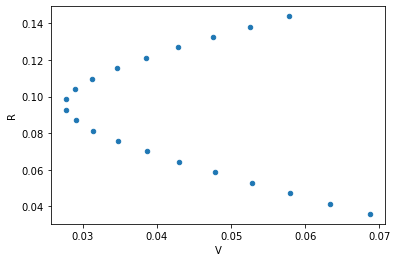

In [14]:
rets = [portfolio_ret(w, retornos_anualizado[l]) for w in pesos]
vols = [portfolio_vol(w, cov_retornos.loc[l,l]) for w in pesos]
front_ef = pd.DataFrame({"R": rets, "V": vols})
front_ef.plot.scatter(x="V", y="R")

In [15]:
pesos[11]

array([0.57894737, 0.42105263])

Podemos criar uma função que traça a fronteira:

In [16]:
def plot_front_ef(n_ptos, rets, cov):
    """
    Plota a fronteira eficiente de 2 ativos
    """
    if rets.shape[0] != 2 or rets.shape[0] != 2:
        raise ValueError("plot_front_ef pode plotar somente a fronteira de 2 ativos")
    pesos = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_ptos)]
    rets_ = [portfolio_ret(w, rets) for w in pesos]
    vols_ = [portfolio_vol(w, cov) for w in pesos]
    ef = pd.DataFrame({
        "Retornos": rets_, 
        "Volatilidade": vols_
    })
    return ef.plot.line(x="Volatilidade", y="Retornos", style=".-")

Um resumo útil dos recursos de visualização em pandas pode ser visto [aqui](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)

<AxesSubplot:xlabel='Volatilidade'>

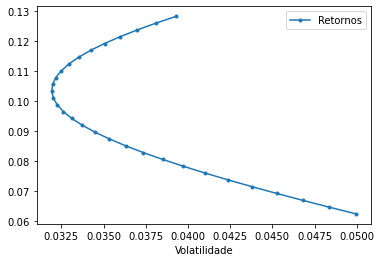

In [17]:
l = ["OURO", "S&P500"]
plot_front_ef(30, retornos_anualizado[l].values, cov_retornos.loc[l,l])